In [480]:
import os
import sys
import numpy as np
from collections import defaultdict, Counter
import time
from matplotlib import pyplot
import json5
from matplotlib import pyplot as pyplot
from scipy.cluster.hierarchy import dendrogram

import importlib
import abxportinf
import abxportinf._grouper
import abxportinf._optimize
import abxportinf._vectorizer
import abxportinf.busdef
import abxportinf.main 
from abxportinf.busdef import BusDef
from abxportinf._optimize import MatchCost

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [471]:
block_root = '/ip-block-designs'
bus_spec_rootdir = '/bus-defs/specs'

In [470]:
pcie_json_path = os.path.join(
    block_root,
    'plda-pcie-controller',
    'PLDA_ws.json5',
)
ddr_json_path = os.path.join(
    block_root,
    'ddr',
    'ddr.json5',
)
pcie_ports = abxportinf.get_ports_from_json5(pcie_json_path)
ddr_ports = abxportinf.get_ports_from_json5(ddr_json_path)

In [481]:
bus_defs = abxportinf.load_bus_defs(bus_spec_rootdir)

loading 22 bus specs
  - done, loaded 38 bus defs with 417 required and 547 optional ports 


In [ ]:
stime = time.time()

ddr_pg_bus_mappings = abxportinf.get_bus_matches(ddr_ports, list(bus_defs))

etime = time.time()
print('total time: {}s'.format(etime-stime))

hierarchically clustering ports and selecting port groups
  - done
initial bus pairing with port groups
  - done
bus mapping


In [439]:
stime = time.time()

pcie_pg_bus_mappings = abxportinf.get_bus_matches(pcie_ports, list(bus_defs))

etime = time.time()
print('total time: {}s'.format(etime-stime))

total time: 177.50690627098083s


In [440]:
def dump_mappings(path, pg_bus_mappings):
    
    def indent_str(s, n=1):
        sn = s.startswith('\n')
        en = s.endswith('\n')
        indent= '\t'
        ss = indent*n + s.strip().replace('\n', '\n' + indent*n)
        return ss+'\n' if en else ss
    
    with open(path, 'w') as fout:
        for port_group, bus_mappings in sorted(
            pg_bus_mappings,
            key=lambda x: len(x[0]),
            reverse=True,
            #key=lambda x: x[1][0][0],
        ):
            lbm = bus_mappings[0]
            if lbm[0].dc >= 25:
                continue
            fout.write('port group\n')
            fout.write(str(list(sorted(port_group)))+'\n')
            for bm in bus_mappings:
                bd = bm[-1]
                fout.write(indent_str('{} {}\n'.format(bd.abstract_type, bd.driver_type)))
                fout.write(indent_str('cost:{}, fcost:{}\n'.format(bm[0], bm[1])))
                if bd.abstract_type.name in [
                    'AXI4_rtl',
                    'AXI4Stream_rtl',
                    'SPRAM_rtl',
                    'DPRAM_rtl'
                ]:
                    debug_str = abxportinf.debug_bus_mapping(port_group, bm)
                    fout.write(indent_str(debug_str, n=2))
    
def dump_nonaxi_dendogram(path, ports):
    assert path.endswith('.pdf')
    nonaxi_ports = list(filter(
        lambda p: not p[0].startswith('axi'),
        ports,
    ))
    _, Z, wire_names = abxportinf.get_port_grouper(nonaxi_ports)
    fig, ax = pyplot.subplots(1,1, figsize=(10,40))
    _ = dendrogram(
        Z,
        ax=ax,
        orientation='left',
        labels=wire_names,
    )
    pyplot.savefig(path)


In [441]:
dump_mappings('ddr-mappings.txt', ddr_pg_bus_mappings)
dump_mappings('pcie-mappings.txt', pcie_pg_bus_mappings)

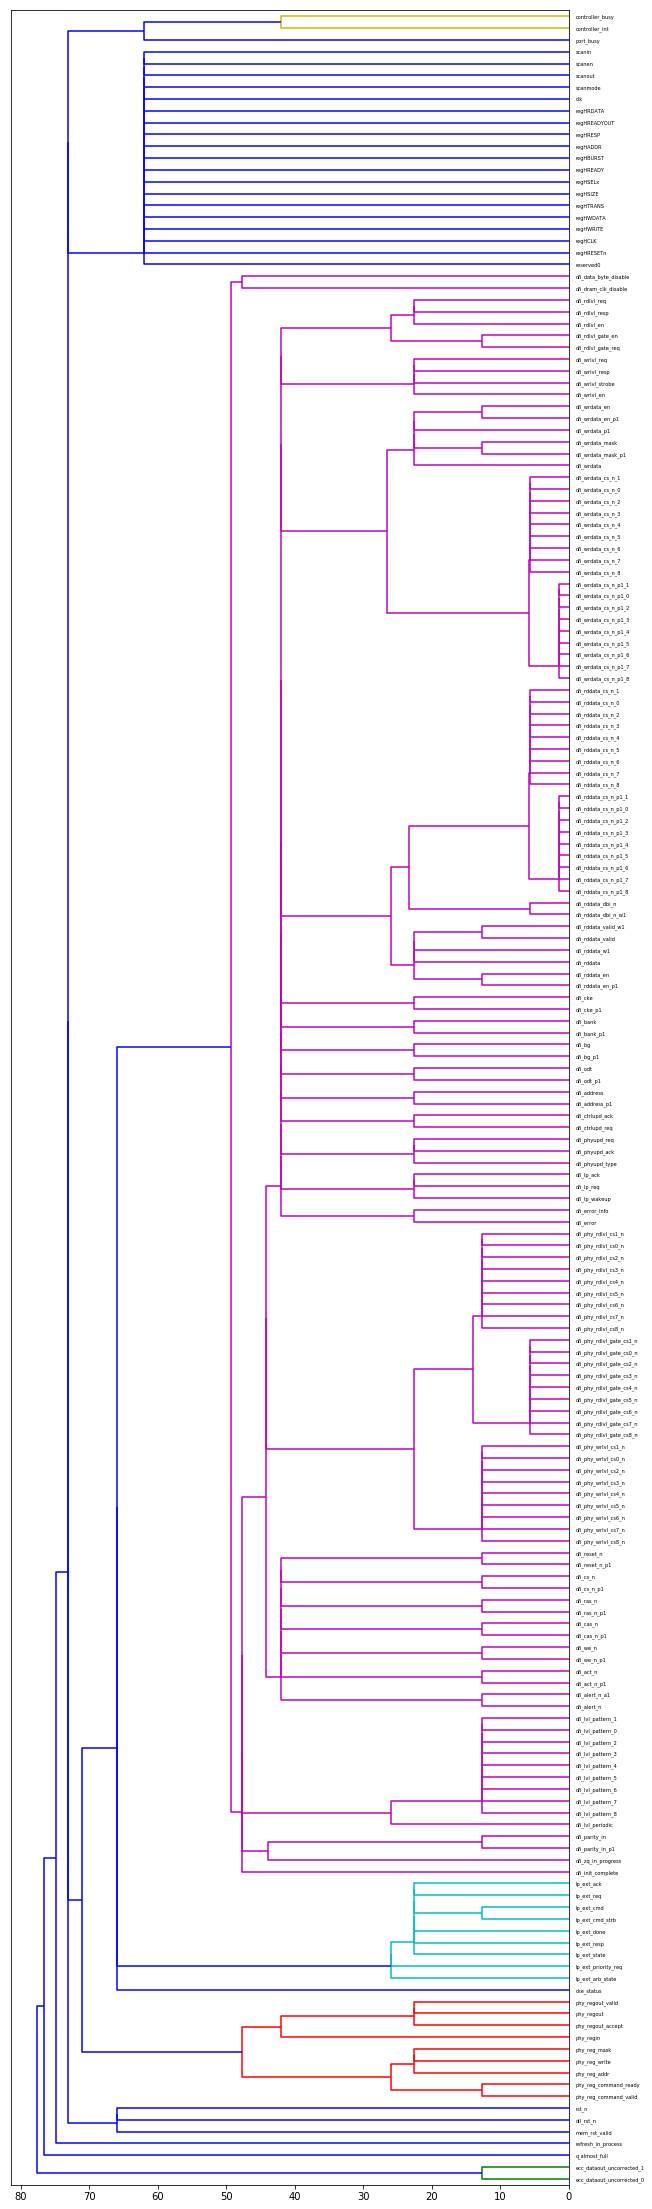

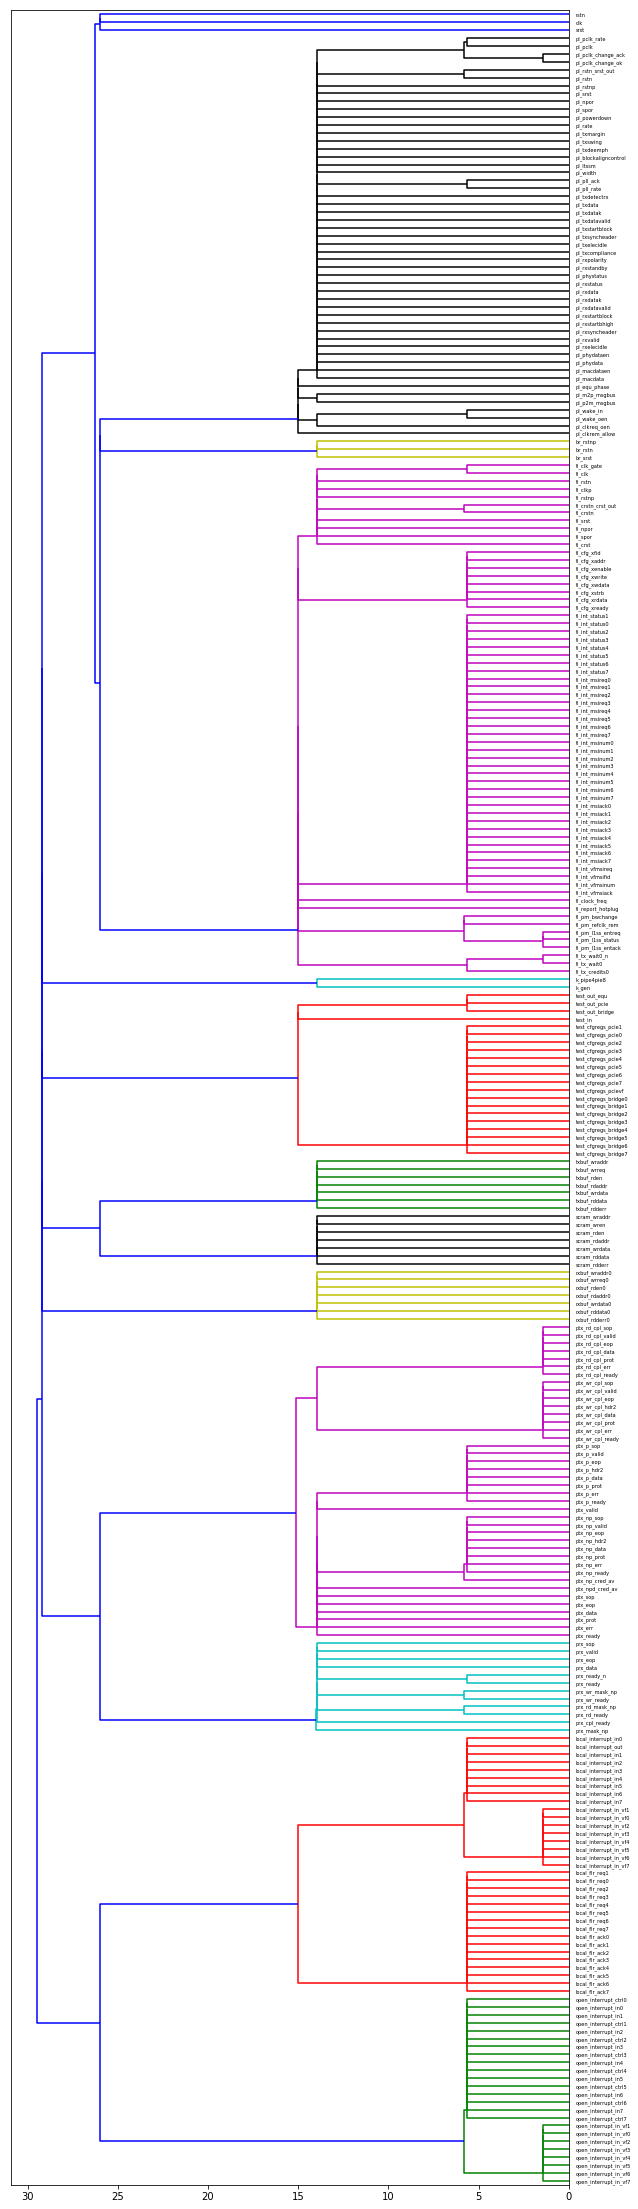

In [402]:
dump_nonaxi_dendogram('ddr-nonaxi-dendogram.pdf', ddr_ports)
dump_nonaxi_dendogram('pcie-nonaxi-dendogram.pdf', pcie_ports)

In [466]:
util.dump_json_bus_candidates('ddr-busprop.json', ddr_pg_bus_mappings)
util.dump_json_bus_candidates('pcie-busprop.json', pcie_pg_bus_mappings)